In [1]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

font = {
    "size": 20
}

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

import sys
sys.path.append("../../")
from utils import metrics
from utils.logger import Logger
import logging
from models.LeNet5 import LeNet5IMG

device = "cuda" if torch.cuda.is_available() else "gpu"
print(f"Using device: {device}.")

Using device: cuda.


In [2]:
# CNN 网络模型
model = LeNet5IMG().to(device)
summary(model, (3, 15, 15))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             208
              ReLU-2           [-1, 16, 14, 14]               0
         MaxPool2d-3             [-1, 16, 7, 7]               0
              ReLU-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 32, 6, 6]           2,080
              ReLU-6             [-1, 32, 6, 6]               0
         MaxPool2d-7             [-1, 32, 3, 3]               0
              ReLU-8             [-1, 32, 3, 3]               0
            Conv2d-9             [-1, 16, 4, 4]           2,064
             ReLU-10             [-1, 16, 4, 4]               0
           Conv2d-11             [-1, 16, 3, 3]           1,040
             ReLU-12             [-1, 16, 3, 3]               0
           Linear-13                   [-1, 50]           7,250
             ReLU-14                   

In [3]:
# 自定义电池数据集
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sequence, target = self.data[index]
        return torch.tensor(sequence, dtype=torch.float32).reshape(3, 15, 15), torch.tensor([target], dtype=torch.float32)

In [4]:
# 读取数据
data_path = "../../data/processed_data/tri/viq/"
data_files = sorted(glob.glob(os.path.join(data_path, "*.npy")))

for data_file in data_files:
    print(data_file)

# load_data_test = np.load(data_files[0], allow_pickle=True)
# print(type(load_data_test), load_data_test.shape) # <class 'numpy.ndarray'> (11903, 2)
# print(load_data_test[0][0].shape, load_data_test[0][1].shape) # (3, 225) ()

# print(np.load(data_files[0], allow_pickle=True).shape[0] + np.load(data_files[1], allow_pickle=True).shape[0])
# dataset_test = []
# for i in range(2):
#     dataset_test += np.load(data_files[i], allow_pickle=True).tolist()
# print(len(dataset_test))

# 电池组编号和电池编号的映射
battery_map = {0: [0, 1, 2, 3], 1: [4, 5, 6, 7], 2: [8, 9, 10, 11], 3: [12, 13, 14, 15]}

../../data/processed_data/tri/viq/b3c00.npy
../../data/processed_data/tri/viq/b3c01.npy
../../data/processed_data/tri/viq/b3c02.npy
../../data/processed_data/tri/viq/b3c03.npy
../../data/processed_data/tri/viq/b3c04.npy
../../data/processed_data/tri/viq/b3c05.npy
../../data/processed_data/tri/viq/b3c06.npy
../../data/processed_data/tri/viq/b3c07.npy
../../data/processed_data/tri/viq/b3c08.npy
../../data/processed_data/tri/viq/b3c09.npy
../../data/processed_data/tri/viq/b3c10.npy
../../data/processed_data/tri/viq/b3c11.npy
../../data/processed_data/tri/viq/b3c12.npy
../../data/processed_data/tri/viq/b3c13.npy
../../data/processed_data/tri/viq/b3c14.npy
../../data/processed_data/tri/viq/b3c15.npy


In [5]:
# 划分训练集和测试集
def get_train_test_dataset(experiment_id, train_group, test_group, logger):
    
    # 训练/测试电池编号
    train_batteries = [battery for group in train_group for battery in battery_map[group]]
    test_batteries = battery_map[test_group]

    # 输出实验信息到日志
    # print(f"experiment id: {experiment_id + 1}")
    # print(f"training dataset batteries index: {train_batteries}")
    # print(f"testing dataset batteries index: {test_batteries}")
    logger.info(f"experiment id: {experiment_id + 1}")
    logger.info(f"training dataset batteries index: {train_batteries}")
    logger.info(f"testing dataset batteries index: {test_batteries}")
    
    train_dataset = []
    test_dataset = []

    # 合并成一个数据集
    for i in train_batteries:
        # print(data_files[i])
        train_dataset += np.load(data_files[i], allow_pickle=True).tolist()
    # 不合并成一个数据集
    for j in test_batteries:
    #     # print(data_files[j])
        test_dataset.append(np.load(data_files[j], allow_pickle=True).tolist())
        # test_dataset += np.load(data_files[j], allow_pickle=True).tolist()
        
    train_dataset = BatteryDataset(train_dataset)

    return train_dataset, test_dataset

2023-06-16 18:28:48,345 - tri_viq_cnn_trans - INFO - experiment id: 1
2023-06-16 18:28:48,346 - tri_viq_cnn_trans - INFO - training dataset batteries index: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2023-06-16 18:28:48,347 - tri_viq_cnn_trans - INFO - testing dataset batteries index: [0, 1, 2, 3]


Save log to: ../../logs/2023_06_16_18_28_tri_viq_cnn_trans.log


2023-06-16 18:28:49,249 - tri_viq_cnn_trans - INFO - dataloader info: shape of X is torch.Size([128, 3, 15, 15]), shape of y is torch.Size([128, 1])
2023-06-16 18:28:49,252 - tri_viq_cnn_trans - INFO - 训练开始
2023-06-16 18:29:50,611 - tri_viq_cnn_trans - INFO - epoch 10, train loss 0.00013169841970006658, validation loss 0.0
2023-06-16 18:29:50,612 - tri_viq_cnn_trans - INFO - model save to path: ../../checkpoints/tri_viq_cnn_trans/group1_epoch10.pth
2023-06-16 18:30:52,913 - tri_viq_cnn_trans - INFO - epoch 20, train loss 6.777996506991702e-05, validation loss 0.0
2023-06-16 18:30:52,914 - tri_viq_cnn_trans - INFO - model save to path: ../../checkpoints/tri_viq_cnn_trans/group1_epoch20.pth
2023-06-16 18:31:54,387 - tri_viq_cnn_trans - INFO - epoch 30, train loss 4.766762301716555e-05, validation loss 0.0
2023-06-16 18:31:54,387 - tri_viq_cnn_trans - INFO - model save to path: ../../checkpoints/tri_viq_cnn_trans/group1_epoch30.pth
2023-06-16 18:32:56,137 - tri_viq_cnn_trans - INFO - epoc

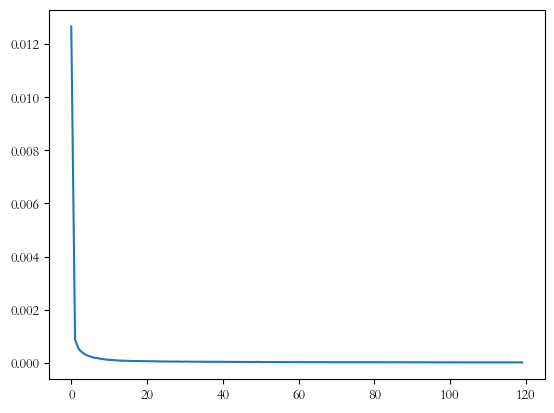

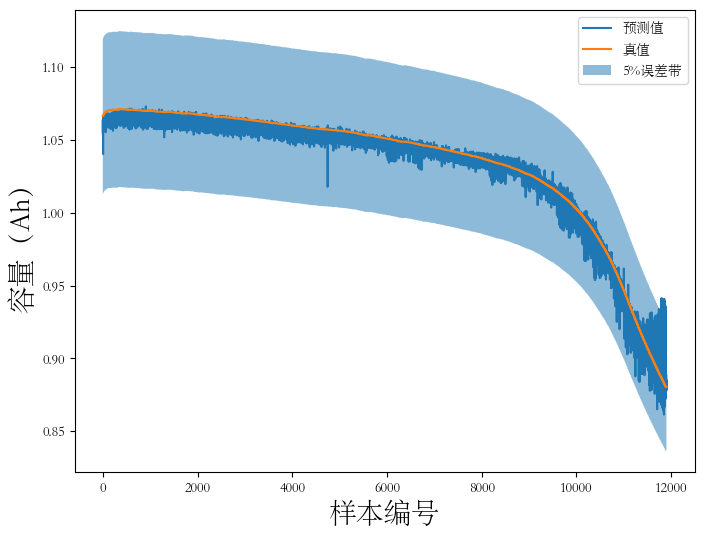

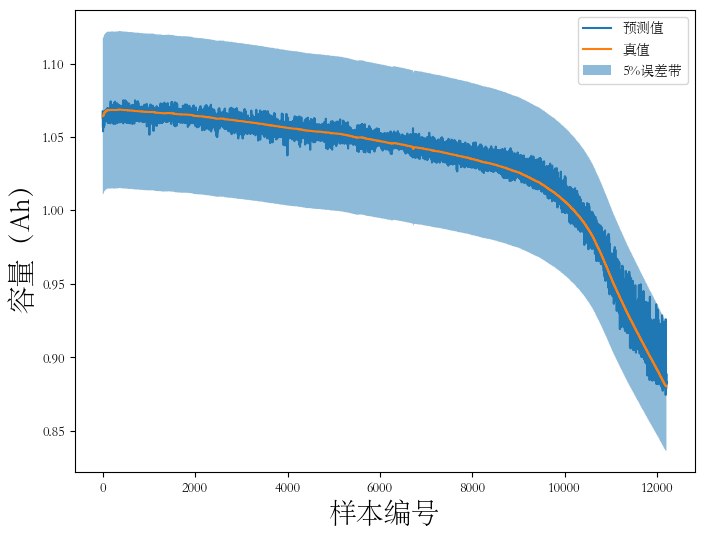

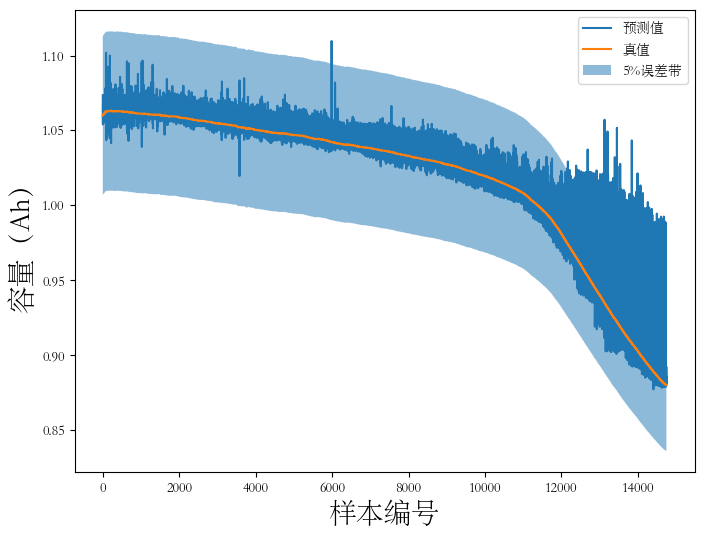

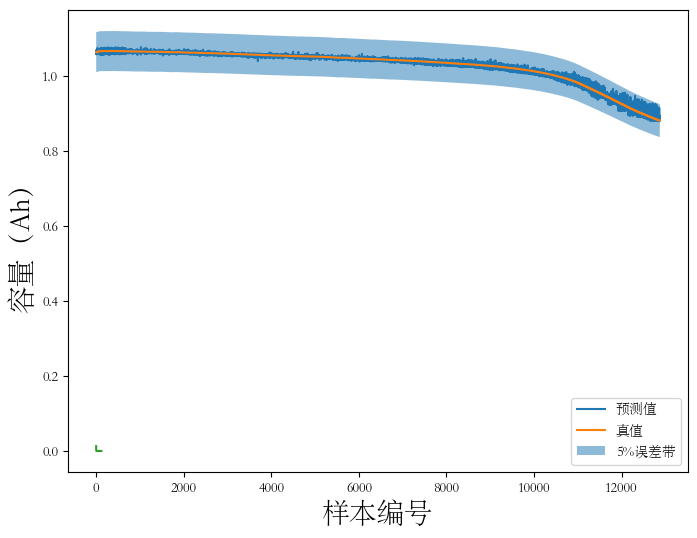

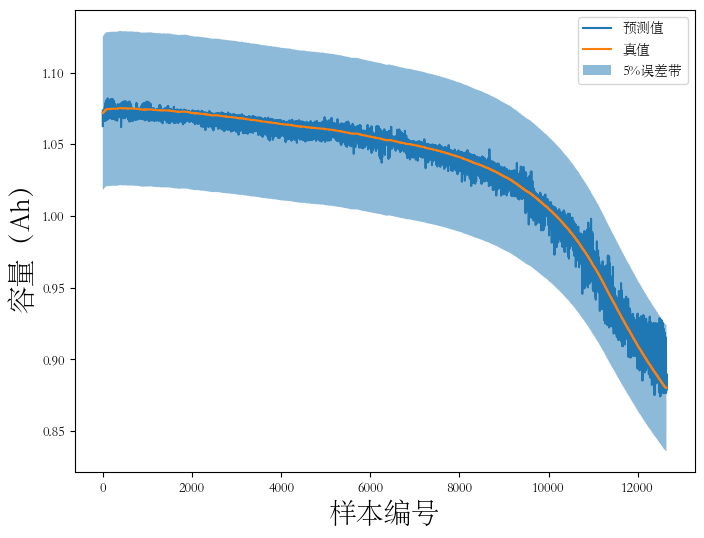

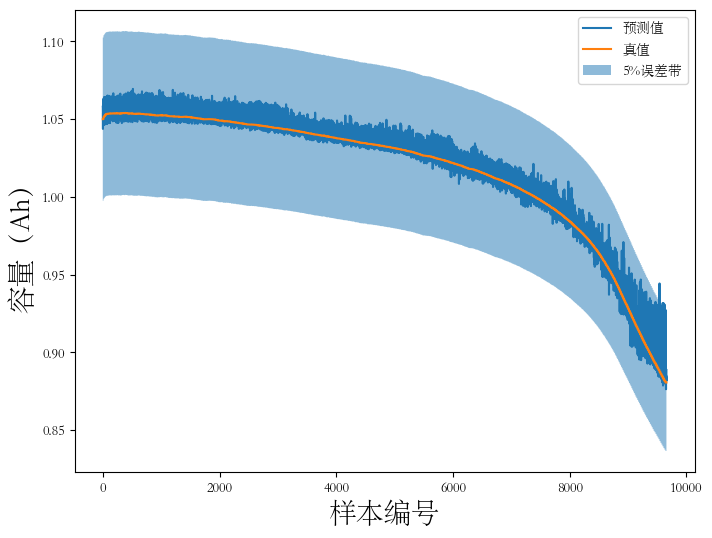

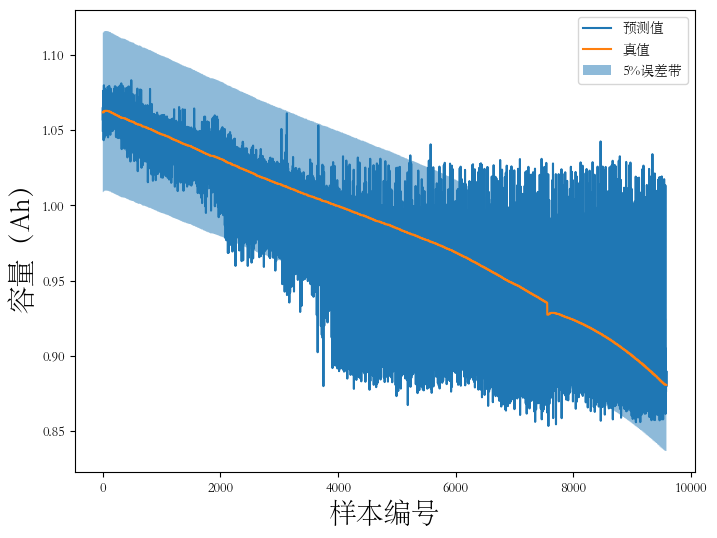

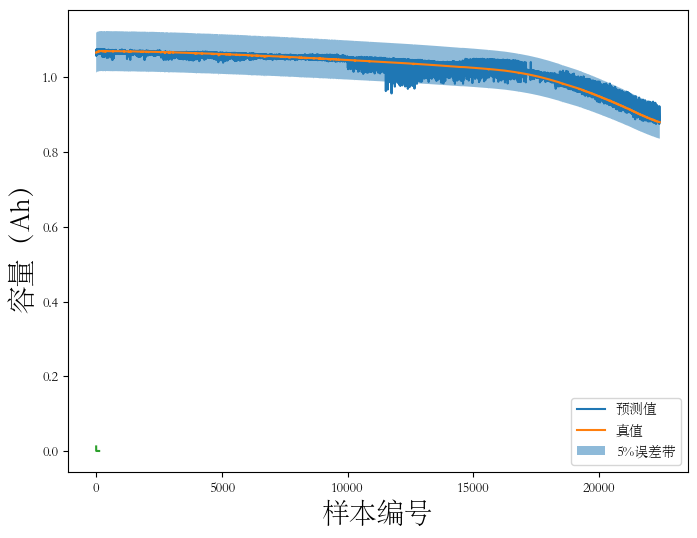

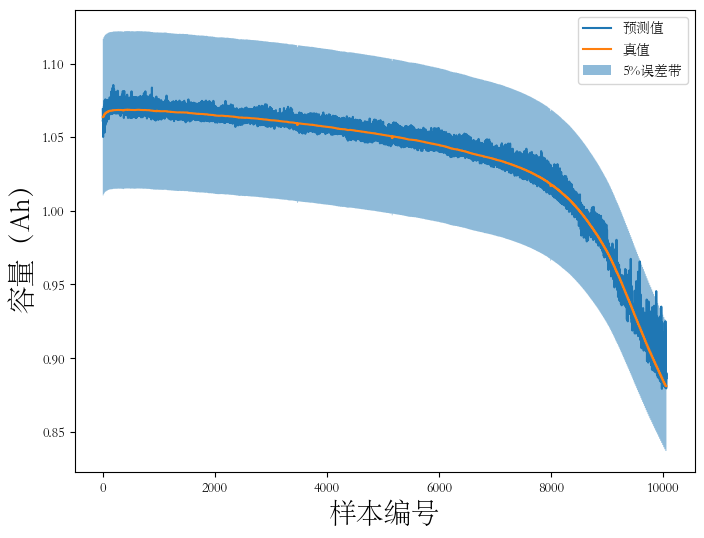

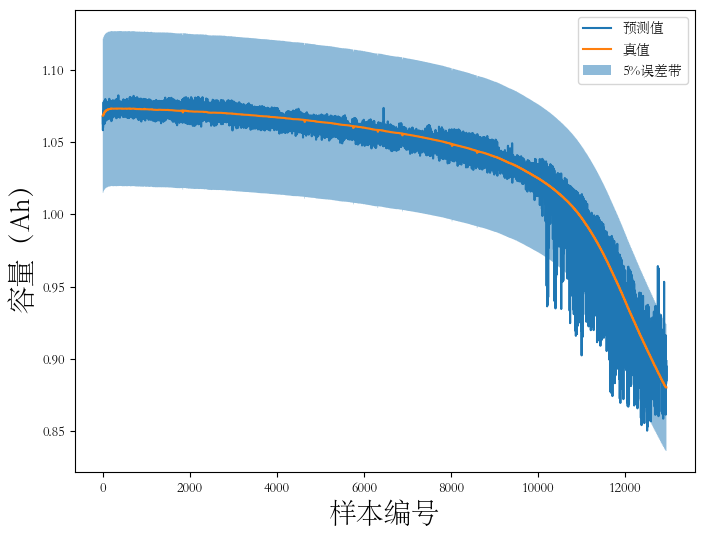

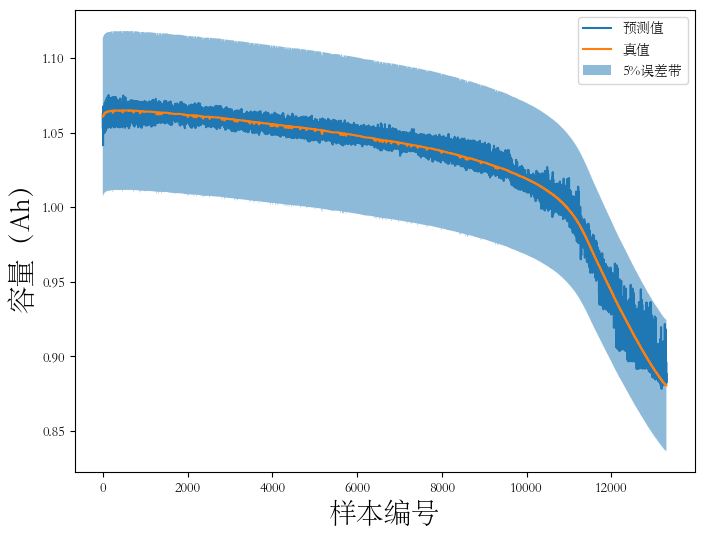

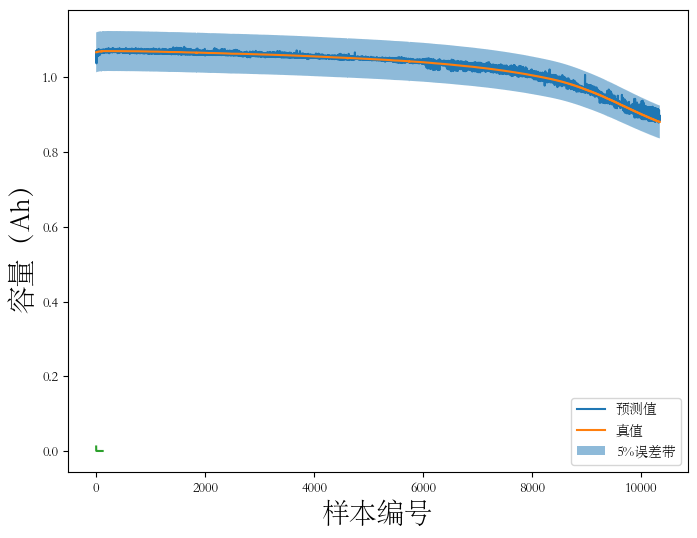

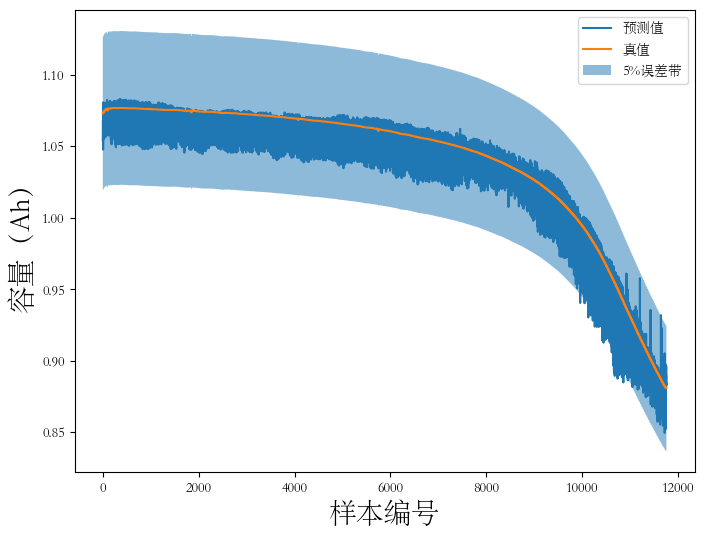

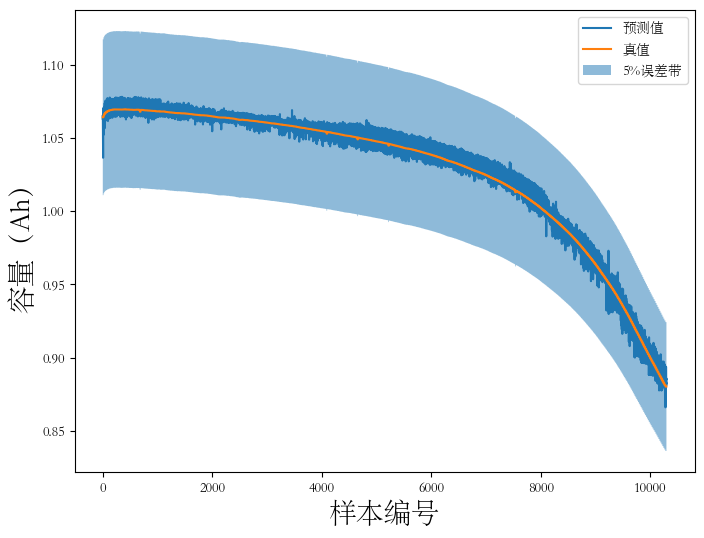

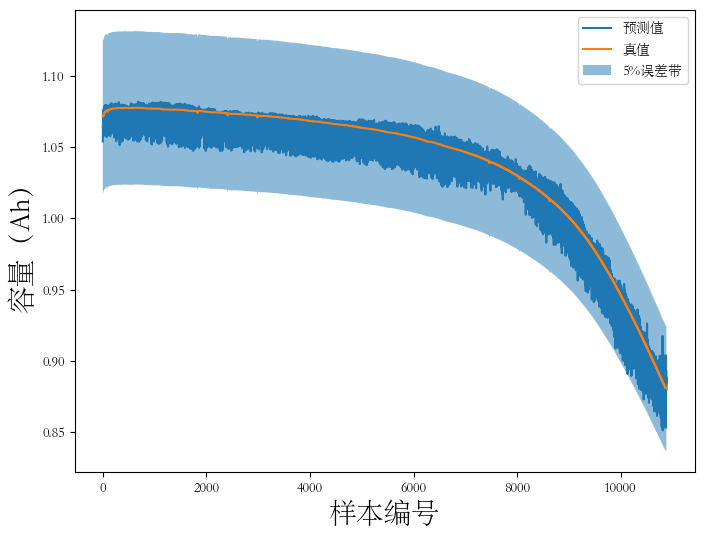

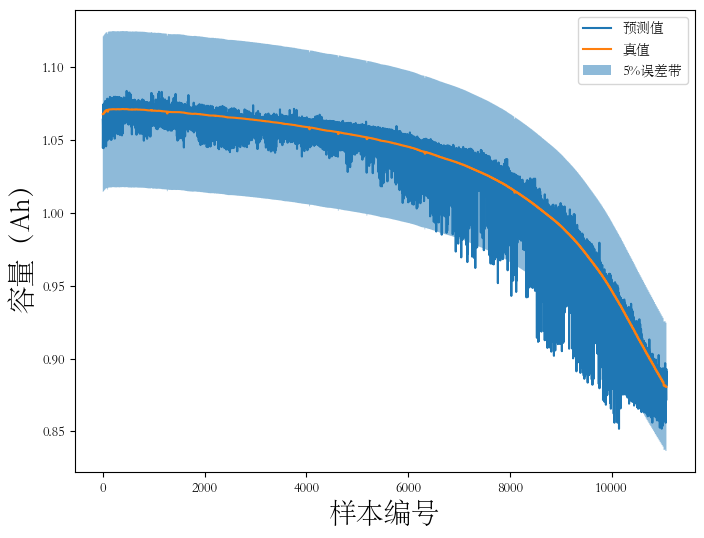

In [6]:
logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="tri_viq_cnn_trans"
    ).get_logger()

# 16块电池分为4组，共进行4组实验
num_cells = 16
num_groups = 4
num_experiments = num_groups
num_cells_per_group = num_cells // num_groups

lr = 1e-3
epochs = 120

# 四组实验
for i in range(num_experiments):

    experiment_id = i
    test_group = i
    train_groups = [group for group in battery_map.keys() if group != test_group]

    train_dataset, test_dataset = get_train_test_dataset(experiment_id, train_groups, test_group, logger)

    batch_size = 128
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    X, y = next(iter(train_dataloader))
    # print(f"dataloader info: shape of X is {X.shape}, shape of y is {y.shape}")
    logger.info(f"dataloader info: shape of X is {X.shape}, shape of y is {y.shape}")

    torch.manual_seed(0)
    model = LeNet5IMG().to(device)
    # model.apply(weight_init)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 模型训练
    train_losses, val_losses = [], []
    # print("开始训练")
    logger.info("训练开始")
    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0.0, 0.0
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            # print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")
            logger.info(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")
            model_root_path = "../../checkpoints/tri_viq_cnn_trans"
            model_save_path = os.path.join(model_root_path, f"group{experiment_id + 1}_epoch{epoch + 1}.pth")
            # print(f"model save to path: {model_save_path}")
            logger.info(f"model save to path: {model_save_path}")
            torch.save(model.state_dict(), model_save_path)

    # print("训练完成")
    logger.info("训练完成")

    plt.plot(train_losses)

    # 模型评估
    for k in range(num_cells_per_group):
        test_dataset_single = test_dataset[k]
        test_dataset_single = BatteryDataset(test_dataset_single)
        test_dataloader = DataLoader(test_dataset_single, batch_size=1)
        gt, pred = [], []

        for X, y in test_dataloader:
            gt.append(float(y))
            pred.append(float(model(X.to(device))))

        pred = np.array(pred)
        gt = np.array(gt)
        cycle = np.arange(len(gt))
        y1 = gt * (1 + 0.05)
        y2 = gt * (1 - 0.05)

        plt.figure(figsize=(8, 6))
        plt.plot(pred)
        plt.plot(gt)
        plt.fill_between(cycle, y2, y1, alpha=0.5)
        plt.legend(["预测值", "真值", "5%误差带"])
        plt.xlabel("样本编号", font)
        plt.ylabel("容量（Ah）", font)
        save_path = f"../../assets/thesis_figures/chapter_4/tri_group{experiment_id + 1}_cell{k + 1}_cnn_viq_trans.jpg"
        plt.savefig(save_path, dpi=1000, bbox_inches="tight")

        maxE, mae, rmse = metrics.evaluation(gt, pred)
        logger.info(f"maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")